# Tutorial 1 - Text Classification - Deep Learning CNN Models

When it comes to text data, sentiment analysis is one of the most widely performed analysis on it. Sentiment Analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

Convolutional Neural Networks or CNNs are the work-horse of the deep learning world. They have, in some sense, brought deep learning research into mainstream discussions. The advancements in the image classification world has left even humans behind.

<img src="https://i.imgur.com/bzwqsZS.png">

In this notebook, we will attempt at performing sentiment analysis utilizing the power of CNNs.

In [2]:
!nvidia-smi

Wed Jul 21 20:51:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 321 kB 10.0 MB/s 
     |████████████████████████████████| 283 kB 42.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85449 sha256=32078478842f0101e1908b1b763b15cb54fced0c23d10eb3195d900f8d5181aa
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_csv("/content/drive/My Drive/NLP_DeepLearning_Course/Week1/movie_reviews.csv.bz2", compression='bz2')
dataset.info()
#dataset = pd.read_csv(r'movie_reviews.csv.bz2', compression='bz2')
#dataset.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Prepare Train-Test Splits

In [8]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

## Text Wrangling and Normalization

In [9]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [10]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:08<00:00, 1812.28it/s]

CPU times: user 27.5 s, sys: 446 ms, total: 27.9 s
Wall time: 27.6 s


## Preprocessing
To prepare text data for our deep learning model, we transform each review into a sequence. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, ``keras`` provides the ``Tokenizer``

In [11]:
t = Tokenizer(oov_token='<UNK>') # oov is 'out of vocabulary'
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0  # all reviews need to be fixed width

In [ ]:
t.word_index.items()


In [20]:
# word at max index, word at min index and index of <UNK>
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]))
print(min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]))
t.word_index['<UNK>']



('dawgis', 175845)
('<PAD>', 0)


1

In [ ]:
list(t.word_index.items())[:40]

In [31]:
# transform train set using the tokenizer
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [33]:
# transform test set using the tokenizer
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
test_sequences


### Preprocessed Dataset Summary

In [35]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175846
Number of Documents=35000


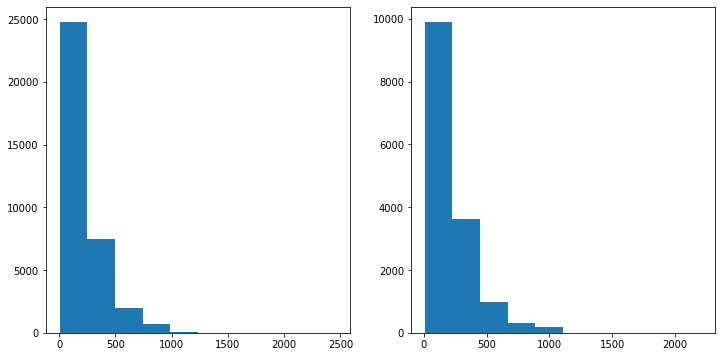

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

## Sequence Normalization
Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [37]:
MAX_SEQUENCE_LENGTH = 1000

In [38]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

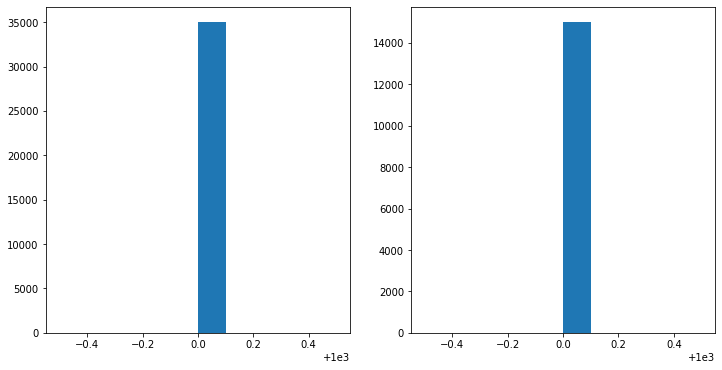

In [39]:
train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

## Encoding Labels
The dataset contains labels of the form positive/negative. The following step encodes the labels using sklearn's LabelEncoder

In [41]:
le = LabelEncoder()
# positive -> 1, negative -> 0
num_classes=2 

In [42]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [43]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model
Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

## Embeddings
The Embedding layer helps us generate the word embeddings from scratch. This layer is also initialized with some weights and is updated based on our optimizer, similar to weights on the neuron units in other layers when the network tries to minimize the loss in each epoch. Thus, the embedding layer tries to optimize its weights such that we get the best word embeddings that will generate minimum error in the model and capture semantic similarity and relationships among words. How do we get the embeddings? Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map consisting of word to index mappings for 175860 words.

<img src="https://i.imgur.com/WuV47DW.png">

## Create the model

In [45]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [46]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         52753800  
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 128)         153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 32)           8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 32)           0

## Train the Model

In [47]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/10
247/247 [==============================] - 103s 350ms/step - loss: 0.4347 - accuracy: 0.7528 - val_loss: 0.2500 - val_accuracy: 0.8920
Epoch 2/10
247/247 [==============================] - 84s 340ms/step - loss: 0.1350 - accuracy: 0.9523 - val_loss: 0.2606 - val_accuracy: 0.9023
Epoch 3/10
247/247 [==============================] - 84s 340ms/step - loss: 0.0291 - accuracy: 0.9903 - val_loss: 0.3704 - val_accuracy: 0.8929
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


## Evaluate Model

In [48]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 6s 14ms/step - loss: 0.2494 - accuracy: 0.8979
Accuracy: 89.79%


In [49]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [50]:
# sample predictions
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.94      0.85      0.89      7490
    positive       0.87      0.94      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6403,1087
positive,445,7065
